In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

In [2]:
def load_img(path_to_img):
    max_dim = 512
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.shape(image)[:-1]
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image

def tensor_to_image(tensor):
    tensor_shape= tf.shape(tensor)
    number_elem_shape = tf.shape(tensor_shape)
    if number_elem_shape > 3:
        assert tensor_shape[0] == 1
        tensor = tensor[0]
    return tf.keras.preprocessing.image.array_to_img(tensor) 

def clip_image_values(image, min_value=0.0, max_value=255.0):
    return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = (image / 127.5) - 1.0

    return image

In [3]:
def imshow(image, title=None):
    if(len(image.shape) > 3):
        image=np.squeeze(image, axis=0)
    plt.imshow(image)
    if(title):
        plt.title(title)

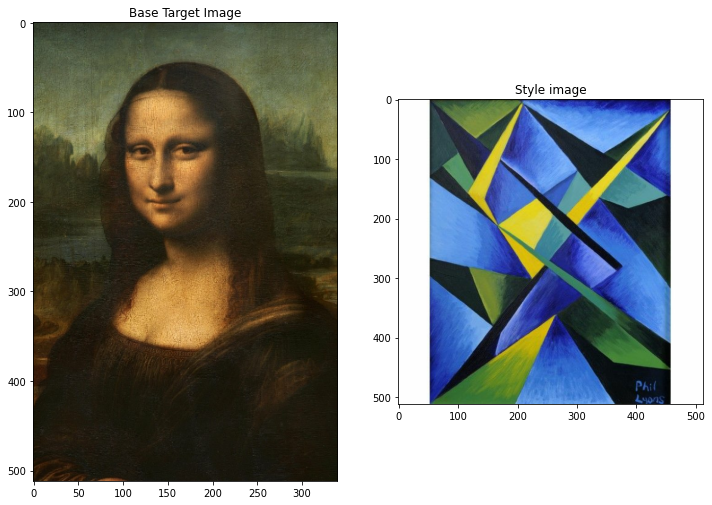

In [4]:
content_image=load_img('../input/nstdatatset/mona_lisa.jpg')
style_image=load_img('../input/nstdatatset/art-style.jpg')

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
imshow(content_image, 'Base Target Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style image')

In [5]:
print(content_image.shape)
print(style_image.shape)

(1, 512, 340, 3)
(1, 512, 512, 3)


In [6]:
content_layers = ['conv2d_93']
style_layers = ['conv2d_1', 
                'conv2d_1', 
                'conv2d_2', 
                'conv2d_3', 
                'conv2d_5']
                      
content_and_style_layers = style_layers + content_layers

NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [7]:
def inception_model(layer_names):  
    inception = tf.keras.applications.inception_v3.InceptionV3(include_top = False, weights= 'imagenet')
    inception.trainable = False
    output_layers = [inception.get_layer(name).output for name in layer_names]
    model = tf.keras.models.Model(inputs = inception.input, outputs = output_layers)
    return model

In [8]:
inception = inception_model(content_and_style_layers)

87916544/87910968 [==============================] - 1s 0us/step


In [9]:
def get_style_loss(features, targets):    
    style_loss =  tf.reduce_mean(tf.square(features - targets)) 
    return style_loss

def get_content_loss(features, targets):
    content_loss =  0.5 * tf.reduce_sum(tf.square(features - targets)) 
    return content_loss

def gram_matrix(input_tensor):
    gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor) 
    height = input_shape[1] 
    width = input_shape[2] 
    num_locations = tf.cast(height * width, tf.float32)
    scaled_gram = gram / num_locations
    return scaled_gram

In [10]:
def get_style_image_features(image):  
    preprocessed_style_image = preprocess_image(image) 
    outputs = inception(preprocessed_style_image) 
    style_outputs = outputs[:NUM_STYLE_LAYERS]
    gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]
    return gram_style_features

def get_content_image_features(image):
    preprocessed_content_image = preprocess_image(image)
    outputs = inception(preprocessed_content_image)
    content_outputs = outputs[NUM_STYLE_LAYERS:]
    return content_outputs

In [11]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
    style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
    content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])
    style_loss =  style_loss * style_weight / NUM_STYLE_LAYERS
    content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 
    total_loss = style_loss + content_loss 
    return total_loss

In [12]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight):
    with tf.GradientTape() as tape:
        style_features = get_style_image_features(image) 
        content_features = get_content_image_features(image) 
        loss =  get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 
    gradients = tape.gradient(loss, image) 
    return gradients

In [13]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            content_weight, optimizer):
    gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight) 
    optimizer.apply_gradients([(gradients, image)])

    image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [14]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       optimizer='adam', epochs=1, steps_per_epoch=1):
    images = []
    step = 0

    style_targets = get_style_image_features(style_image)
    
    content_targets = get_content_image_features(content_image)
    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image) 
    images.append(content_image)
  
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, content_weight, optimizer)
            print(".", end='')
            if (m + 1) % 10 == 0:
                images.append(generated_image)
    
        clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)
        images.append(generated_image)
        print("Train step: {}".format(step))
    generated_image = tf.cast(generated_image, dtype=tf.uint8)
    
    return generated_image, images

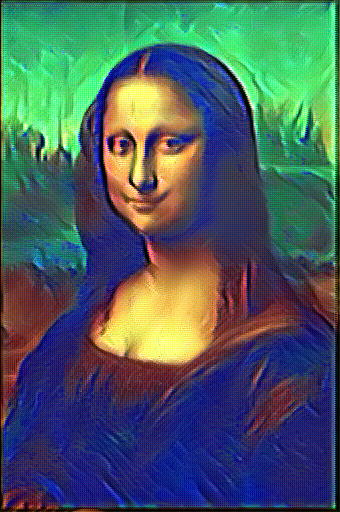

Train step: 500


In [15]:
style_weight =  1e-2
content_weight = 1e-5

adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=60.0, decay_steps=100, decay_rate=0.80
    )
)

stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=5, steps_per_epoch=100)